In [1]:
!pip install findspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 39 kB/s 
     |████████████████████████████████| 199 kB 52.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=7a52f2b86bee1f8883baa8091fa3cbbd0a955d445ac877727a1b6a6caf4502a5
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [7]:
import os
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark import ml
from pyspark import mllib
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier

In [3]:
def init_spark(app_name: str):
  spark = SparkSession.builder.appName(app_name).getOrCreate()
  sc = spark.sparkContext
  return spark, sc

spark, sc = init_spark('demo')
sc

<SparkContext master=local[*] appName=demo>

In [9]:
dataPath_hw = "/content/data.json"

data_df = spark.read.format("json")\
  .option("header","true")\
  .option("escape", "\"")\
  .option("inferSchema", "true")\
  .load(dataPath_hw)

# **Model Creation**

# Pipeline:

In [29]:
transformer_pipeline = Pipeline(stages=[
    StringIndexer(inputCols=["Device",'gt', 'User'],\
                  outputCols=["Device_idx", "gt_idx", 'User_idx']),
    OneHotEncoder(inputCol="Device_idx", outputCol="Device_vec"),
    OneHotEncoder(inputCol="User_idx", outputCol="User_vec"),
    VectorAssembler(inputCols=["Device_vec", "Index", 'User_vec','x','y','z'], outputCol="features")
    ])
model = transformer_pipeline.fit(data_df)


train_set, test_set = model.transform(data_df).select('features','gt','gt_idx').randomSplit([0.7,0.3])

# Train model:

In [30]:
model_rf = RandomForestClassifier(labelCol="gt_idx", featuresCol="features", maxDepth=30,
                                  numTrees=3, minInstancesPerNode=100)
model_rf_fitted = model_rf.fit(train_set)

# Evaluate:

In [31]:
evaluator=MulticlassClassificationEvaluator(labelCol='gt_idx',predictionCol="prediction", metricName='accuracy')
pred_rf_train = model_rf_fitted.transform(train_set)
pred_rf_test = model_rf_fitted.transform(test_set)
print(f'Random Forest Accuracy Train set: {evaluator.evaluate(pred_rf_train)}')
print(f'Random Forest Accuracy Test set: {evaluator.evaluate(pred_rf_test)}')

Random Forest Accuracy Train set: 0.872812190280934
Random Forest Accuracy Test set: 0.8689882697947214


# **Visualization**

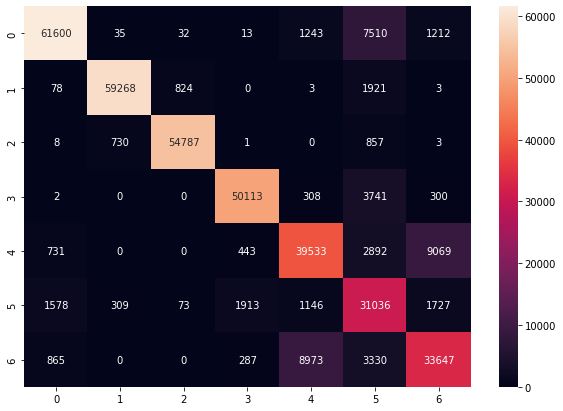

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from pyspark.mllib.evaluation import MulticlassMetrics

pred_list = pred_rf_train.select('gt_idx', 'prediction')
metrics = MulticlassMetrics(pred_list.rdd.map(tuple))
df_cm_2 = pd.DataFrame(metrics.confusionMatrix().toArray(), index = [i for i in range(7)],
                  columns = [i for i in range(7)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm_2, annot=True, fmt='.7g')

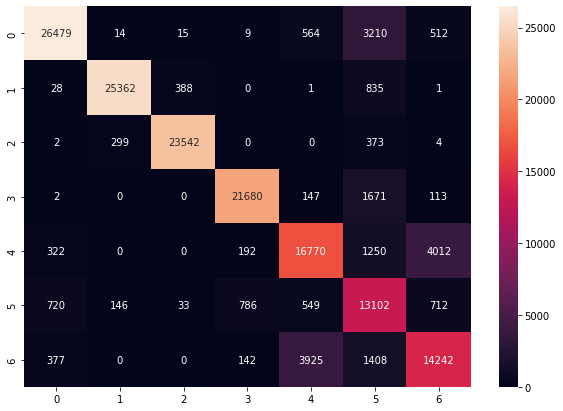

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from pyspark.mllib.evaluation import MulticlassMetrics

pred_list = pred_rf_test.select('gt_idx', 'prediction')
metrics = MulticlassMetrics(pred_list.rdd.map(tuple))
df_cm_2 = pd.DataFrame(metrics.confusionMatrix().toArray(), index = [i for i in range(7)],
                  columns = [i for i in range(7)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm_2, annot=True, fmt='.7g')

# Legend:

In [27]:
train_set.select('gt','gt_idx').distinct().show()

+----------+------+
|        gt|gt_idx|
+----------+------+
|      walk|   0.0|
|       sit|   1.0|
|      null|   5.0|
|      bike|   3.0|
|stairsdown|   6.0|
|  stairsup|   4.0|
|     stand|   2.0|
+----------+------+

